In [1]:
import sys
import numpy as np
np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from itertools import zip_longest
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
import random
import pandas as pd
from numba import njit

In [2]:
SEED = 8
random.seed(SEED)
def shuffle_forward(l):
    order = list(range(len(l)))
    random.shuffle(order)
    return np.array(np.array(l)[order]), order

def shuffle_backward(l, order):
    l_out = [0] * len(l)
    for i, j in enumerate(order):
        l_out[j] = l[i]
    return l_out

# Optimized Functions with Numba

In [3]:
@njit
def nb_LIF(I, dT, V_rest, V_thresh, V_spike, Rm, Cm):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = I.size * dT

        # an array of time
        time = np.arange(0, total_time, dT)

        # default voltage list set to resting volatage of -65mV
        V = V_rest * np.ones(len(time))

        did_spike = False

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - V_rest) / Rm) / Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = V_rest + dV * dT
            else:
                V[t] = V[t - 1] + dV * dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = V_spike
            else:
                did_spike = False

        return V

@njit
def nb_voltage_to_output(V_input, V_spike):
    """Converts a neuron's internal voltage to output"""
    V_output = np.zeros(V_input.shape)
    for i, v in enumerate(V_input):
        V_output[i] = 0 if v < V_spike else V_spike
    return V_output

@njit
def nb_voltage_to_spike_rate(voltages, V_spike, dT, rate):
    """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
#         print('voltages', voltages)
    
    spike_count = 0
    for v in voltages:
        if v >= V_spike:
            spike_count += 1

    #         print('spike_count', spike_count)

    total_time_dT = len(voltages) * dT
    #         print(f'total_time_dT: {total_time_dT} ({dT}ms)')

    spikes_per_dT = spike_count / total_time_dT
    #         print(f'spikes_per_ms: {spikes_per_dT} (spikes/ms)')

    return spikes_per_dT * 1000 * rate

@njit
def nb_new_weight(weight, a_corr, input_rate, output_rate, w_max, w_decay):
    # adjust the weight using Hebb with decay
    weight_change = a_corr * input_rate * output_rate - w_decay
#                         print('\told weight', weight)
#                         print('\tweight_change:', weight_change)
    new_weight = 0
    if weight + weight_change < 0:
        new_weight = 0
    elif weight + weight_change > w_max:
        new_weight = w_max
    else:
        new_weight = weight + weight_change
    return new_weight

In [4]:
class SingleLayerSNN:
    def __init__(
        self,
        inputs,
        weights,
        trainings,
        Cm=4.0,
        Rm=5.0,
        V_thresh=30.0,
        V_rest=-65.0,
        V_spike=80.0,
        dT=0.01,
        rate=1.0,
    ):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """

        assert len(trainings) == len(inputs)

        self.inputs = inputs
        self.weights = weights
        self.trainings = trainings
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT  # ms
        self.rate = rate  # sec
        self._LIF_spikes = 0
    
    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        return nb_LIF(I, self.dT, self.V_rest, self.V_thresh, self.V_spike, self.Rm, self.Cm)
    
    def voltage_to_output(self, V_input):
        """Converts a neuron's internal voltage to output"""
        return nb_voltage_to_output(V_input, self.V_spike)

    def voltage_to_spike_rate(self, voltages, dT=None, rate=None):
        """Converts an array of neuron voltages to spikes per n seconds, where n = rate"""
        if not dT:
            dT = self.dT
        if not rate:
            rate = self.rate
            
        return nb_voltage_to_spike_rate(voltages, self.V_spike, dT, rate)

    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, train=True):
        """
        Passes all sets of inputs to 

                Parameters:
                        inputs (double[][][]): A 3d numpy array that contains every set of inputs voltages for each input neuron
                        train (boolean): Determines whether or not to inject training voltages

                Returns:
                        all_input_voltages, all_output_voltages (double[][][], double[][][]): A tuple of all of the input voltages and all of the output voltages
        """
        all_input_voltages = np.zeros(inputs.shape)
        all_output_voltages = np.zeros(self.trainings.shape)[:len(inputs)]

        # set the training voltages to all zero if not running in training mode
        training_copy = (
            np.zeros(inputs.shape, np.ndarray)
            if not train
            else np.array(self.trainings)
        )
        #         print('training_copy:')
        #         print(training_copy)

        inputs_copy = np.array(inputs)
        #         print('inputs_copy:')
        #         print(inputs_copy)

        assert len(training_copy) == len(inputs_copy)

        zipped = list(zip(inputs_copy, training_copy))
        
        shuffled, order = shuffle_forward(zipped)
        shuffled_inputs, shuffled_trainings = zip(*shuffled)

        shuffled_inputs = np.array(shuffled_inputs)
        #         print('shuffled_inputs:')
        #         print(shuffled_inputs)

        shuffled_trainings = np.array(shuffled_trainings)
        #         print('shuffled_trainings:')
        #         print(shuffled_trainings)
        
        # feed inputs through input neurons to get weighted voltage for output neurons
        for i, (input_set, training_set) in enumerate(zip_longest(shuffled_inputs, shuffled_trainings)):
            
            for j, V_input in enumerate(input_set):
                temp = np.array(V_input)
                all_input_voltages[i][j] = self.LIF(temp.astype(float))
            input_voltages = all_input_voltages[i]
            
            output_inputs = np.zeros(self.trainings[0].shape)
#             input_outputs = []  # DEBUG ONLY
            for j, weight_set in enumerate(self.weights.T):
                weighted_sum = np.zeros(len(input_set[0]))
                for V_input, weight in zip(input_voltages, weight_set):
                    # filter for spikes b/c a neuron only outputs if it spikes
                    input_output = self.voltage_to_output(V_input)
#                     input_outputs.append(input_output)  # DEBUG ONLY
                    weighted = input_output * weight
                    weighted_sum = np.add(weighted_sum, weighted)

                output_inputs[j] = weighted_sum

#             input_outputs = np.array(input_outputs)

            #             print('input_voltages:')
            #             print(input_voltages)
            #             print('input_outputs:')
            #             print(input_outputs)
            #             print('output_inputs:')
            #             print(output_inputs)
            #             print('training_set:')
            #             print(training_set)

            # inject training voltage if in training mode
            assert isinstance(training_set, (list, np.ndarray))
            for j, (output_input, training_input) in enumerate(
                zip(output_inputs, training_set)
            ):
                assert isinstance(training_input, (list, np.ndarray))
#               padded_training_input = np.pad(training_input, (0, len(output_inputs) - len(training_set)), "constant")
                output_inputs[j] = output_input + training_input

#             print('output_inputs after injecting training current')
#             print(output_inputs)

            # run LIF on output neurons
            for j, V_input in enumerate(output_inputs):
                all_output_voltages[i][j] = self.LIF(V_input)
                            
#             output_voltages = all_output_voltages[i]
#             print('output_voltages:')
#             print(output_voltages)

        # unshuffle the voltages
        all_input_voltages = np.array(shuffle_backward(all_input_voltages, order))
        all_output_voltages = np.array(shuffle_backward(all_output_voltages, order))
        return all_input_voltages, all_output_voltages

    def train(self, epochs=75, a_corr=0.000000002, w_max=2, w_decay=0, show_legend=True, print_weights=True):
        """Runs feed forward with training dataset"""
        weights_history = []
        for weight_set in self.weights:
            weight_row = []
            for weight in weight_set:
                weight_row.append([weight])
            weights_history.append(weight_row)

        for epoch in range(epochs):
            print(f"Epoch: {epoch + 1}")
            
            print('\trunning feed forward...')
            all_input_voltages, all_output_voltages = self.feed_forward(
                self.inputs, train=True
            )

            # debug info
            #             print()
            #             print('------------------------------------------------')
            #             print('all_input_voltages:')
            #             print(all_input_voltages)
            #             print('all_output_voltages:')
            #             print(all_output_voltages)

            #             print('weights:')
            #             print(self.weights)
            
            print('\tapplying learning rule...')
            # apply learning rule
            for input_voltages, output_voltages in zip(
                all_input_voltages, all_output_voltages
            ):
#                 print('input_voltages:')
#                 print(input_voltages)
                for i, (input_voltage_set, weight_set) in enumerate(
                    zip(input_voltages, self.weights)
                ):
#                     print('input_voltage_set', input_voltage_set)
                    input_rate = self.voltage_to_spike_rate(input_voltage_set)
#                     print(f'input_rate {i}:', input_rate)

                    for j, (output_voltage_set, weight) in enumerate(
                        zip(output_voltages, weight_set)
                    ):
                        output_rate = self.voltage_to_spike_rate(output_voltage_set)
#                         print(f'\toutput_rate {j}:', output_rate)

                        # adjust the weight using Hebb with decay
                        self.weights[i][j] = nb_new_weight(self.weights[i][j], a_corr, input_rate, output_rate, w_max, w_decay)

#                         print('\tnew weight', self.weights[i][j], '\n')

            # update weight history
            for i, weight_set in enumerate(self.weights):
                for j, weight in enumerate(weight_set):
                    weights_history[i][j].append(weight)
            if print_weights:
                print('\tweights:')
                print('\t' + str(self.weights).replace('\n','\n\t'))

        # plot neuron spiking data
        #             for i, (input_voltages, output_voltages) in enumerate(zip(all_input_voltages, all_output_voltages)):
        #                 plt.figure(figsize=(20,10))
        #                 plt.title(f'Input: {i + 1}')
        #                 for input_voltage in input_voltages:
        #                     plt.plot(input_voltage, 'b:', alpha=.5)

        #                 for output_voltage in output_voltages:
        #                     plt.plot(output_voltage, 'r--', alpha=.5)

        #             plt.show()

        # plot weights history
        plt.figure(figsize=(20, 10))
        for i, weight_row in enumerate(weights_history):
            for j, weight_history in enumerate(weight_row):
                plt.plot(weight_history, label=f"weight {i}-{j}")
                plt.xlabel('Epoch')
        if show_legend:
            plt.legend(loc="upper left")
        plt.title("Weight History")
        plt.show()
        
    def _generate_bar_plot(self, outputs, title='', ylabel='', stacked=False):
        d = {}
        """Generates bar plot for output neuron data"""
        for x, bars in enumerate(outputs.T):
            d[f'Output Neuron {x}'] = bars
        index = [f'{x}' for x in range(len(outputs.T[0]))]
        df = pd.DataFrame(d, index=index)
        ax = df.plot.bar(rot=0, figsize=(20, 10), stacked=stacked, title=title)
        ax.set_xlabel('Input Set')
        ax.set_ylabel(ylabel)

    def predict(self, inputs, show_plots=True):
        """Runs feed foward without training data on inputs"""
        all_input_voltages, all_output_voltages = self.feed_forward(inputs, train=False)
#         print('all_output_voltages')
#         print(all_output_voltages)

        all_output_confidences = []
        all_output_spike_rates = []

        for x, (input_voltages, output_voltages) in enumerate(
            zip(all_input_voltages, all_output_voltages)
        ):
            output_spike_rates = []
            output_confidences = []
            print("input set:", x)
            for i, input_voltage_set in enumerate(input_voltages):
                print(
                    f"\tinput {i}: {self.voltage_to_spike_rate(input_voltage_set)} spikes/{self.rate}s"
                )
            print()

            output_voltages_sum = sum(
                [self.voltage_to_spike_rate(v) for v in output_voltages]
            )
            for i, output_voltage_set in enumerate(output_voltages):
                sr = self.voltage_to_spike_rate(output_voltage_set)
                output_spike_rates.append(sr)
                confidence = (
                    "N/A" if output_voltages_sum == 0 else sr / output_voltages_sum
                )
                output_confidences.append(0 if confidence == "N/A" else confidence)
                print(
                    f"\toutput {i}: {sr} spikes/{self.rate}s, confidence: {confidence}"
                )
            print()
            all_output_spike_rates.append(output_spike_rates)
            all_output_confidences.append(output_confidences)

        all_output_confidences = np.array(all_output_confidences)
        all_output_spike_rates = np.array(all_output_spike_rates)

        #         print(all_output_confidences)
        #         print(all_output_spike_rates)
        if show_plots:
            # plot output confidence
            self._generate_bar_plot(all_output_confidences, title="Output Confidence", ylabel="Confidence", stacked=True,)
            # plot output spike rates
            self._generate_bar_plot(
                all_output_spike_rates,
                ylabel=f"Spike Rate (spikes/{self.rate}s)",
                title="Output Spike Rates",

            )
        return all_input_voltages, all_output_voltages, all_output_confidences, all_output_spike_rates


# Logical AND

In [5]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

and_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR AND NETWORK: epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001
# and_network.train(epochs=77, a_corr=0.000000002, w_max=2.0, w_decay=0.0001)

p_a = 10000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> F
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> F
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)

# and_network.predict(predict_inputs);


# Logical OR

In [6]:
u_t = 2000  # units of time
i_a = 1000.0  # input amount

# NOTE: we want the same number of training inputs for each output class
inputs = np.array(
    [
        [[i_a] * u_t, [0.0] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[i_a] * u_t, [0.0] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [i_a] * u_t, [i_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F
        [[0.0] * u_t, [i_a] * u_t, [0.0] * u_t, [i_a] * u_t],  # x: F, y: F --> F

    ]
)

t_a = 1000.0  # training amount
s_a = -100.0  # supress amount

# current that gets injected to the output neurons
trainings = np.array(
    [
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[t_a] * u_t, [s_a] * u_t],  # T
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
        [[s_a] * u_t, [t_a] * u_t],  # F
    ]
)

# initiate the weights to be half of max weight
weights = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
        [0.0, 0.0],
    ]
)

or_network = SingleLayerSNN(inputs=inputs, weights=weights, trainings=trainings)

# BEST PARAMS FOR OR NETWORK: epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001
# or_network.train(epochs=15, a_corr=0.00000001, w_max=2.0, w_decay=0.00001)

p_a = 100000.0  # predict input amount

# the four possible cases
predict_inputs = np.array(
    [
        [[p_a] * u_t, [0.0] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: T, y: T --> T
        [[p_a] * u_t, [0.0] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: T, y: F --> T
        [[0.0] * u_t, [p_a] * u_t, [p_a] * u_t, [0.0] * u_t],  # x: F, y: T --> T
        [[0.0] * u_t, [p_a] * u_t, [0.0] * u_t, [p_a] * u_t],  # x: F, y: F --> F
    ]
)
# or_network.predict(predict_inputs);


# Digit Classification

In [7]:
digits = load_digits()

u_t = 2000 # units of time
t_a = 1000 # training injection amount
s_a = -100 # training supression amount

pixels_per_digit = len(digits.data[0])
intensity_multiplier = 500
digit_types = 10 # max: 10, min: 1

# preprocess data
complete_set = np.zeros((len(digits.data), pixels_per_digit, u_t), float)
trainings = np.zeros((len(digits.target), digit_types, u_t), float)

for i, (digit, target) in enumerate(zip(digits.data, digits.target)):
    digit_voltage_stream = np.zeros((pixels_per_digit, u_t), float)
    training_voltage_stream = np.zeros((digit_types, u_t), float)
    
    for j, pixel in enumerate(digit):
        digit_voltage_stream[j] = np.array([pixel * intensity_multiplier] * u_t)
         
    assert target < digit_types
    for j in range(digit_types):
        training_voltage_stream[j] = np.array([t_a] * u_t) if j == target else np.array([s_a] * u_t)
        
    complete_set[i] = digit_voltage_stream
    trainings[i] = training_voltage_stream

assert len(trainings) == len(complete_set)    

# partition into training, validation, and test
training_set = complete_set[:-150]
training_trainings = trainings[:-150]

validation_set = complete_set[:-500]
validation_targets = digits.target[:-500]

test_set = complete_set[len(complete_set) - 150:]
test_targets = digits.target[len(complete_set) - 150:]

Epoch: 1
	running feed forward...
	applying learning rule...
Epoch: 2
	running feed forward...
	applying learning rule...
Epoch: 3
	running feed forward...
	applying learning rule...
Epoch: 4
	running feed forward...
	applying learning rule...
Epoch: 5
	running feed forward...
	applying learning rule...
Epoch: 6
	running feed forward...
	applying learning rule...
Epoch: 7
	running feed forward...
	applying learning rule...
Epoch: 8
	running feed forward...
	applying learning rule...
Epoch: 9
	running feed forward...
	applying learning rule...
Epoch: 10
	running feed forward...
	applying learning rule...
Epoch: 11
	running feed forward...
	applying learning rule...
Epoch: 12
	running feed forward...
	applying learning rule...
Epoch: 13
	running feed forward...
	applying learning rule...
Epoch: 14
	running feed forward...
	applying learning rule...
Epoch: 15
	running feed forward...
	applying learning rule...
Epoch: 16
	running feed forward...
	applying learning rule...
Epoch: 17
	runnin

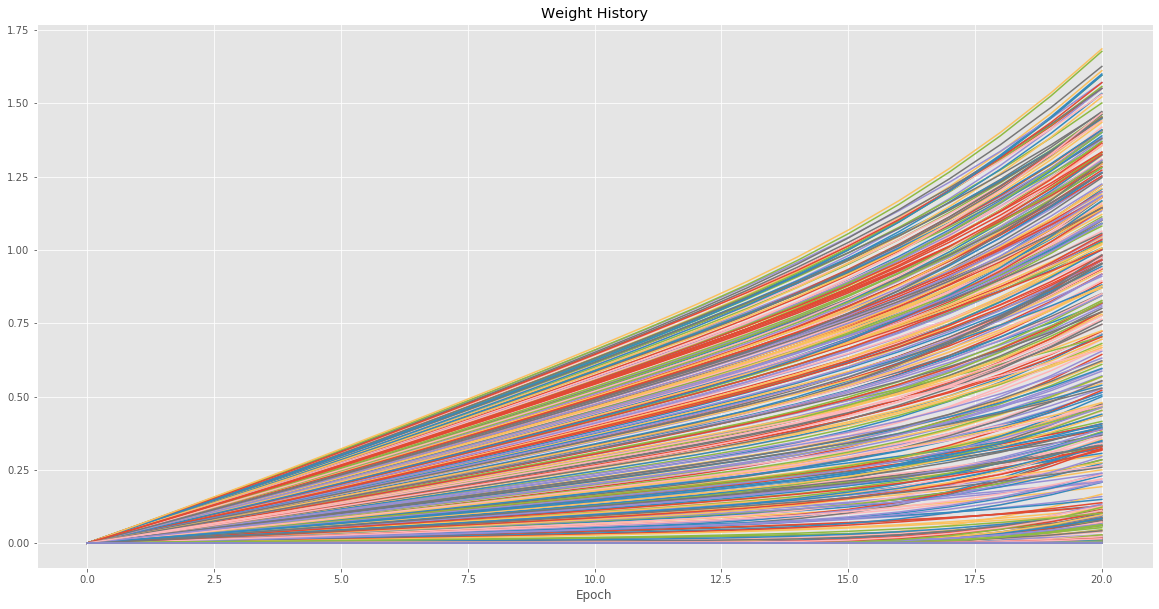

In [35]:
# create & train network
weights = np.zeros((pixels_per_digit, digit_types))
digit_network = SingleLayerSNN(inputs=training_set, weights=weights, trainings=training_trainings)
digit_network.train(epochs=22, a_corr=0.00000000001, w_max=2.0, w_decay=0.00000, show_legend=False, print_weights=False)

In [25]:
def has_duplicate(l, n):
    seen = False
    for x in l:
        if x == n:
            if seen:
                return True
            else:
                seen = True
    return False

def digit_stats(output_spike_rates, targets):
    correct_digits_stats = np.zeros(10)
    encountered_digits_stats = np.zeros(10)

    for output_spike_rates, target in zip(all_output_spike_rates, targets):
        encountered_digits_stats[target] += 1

        max_voltage = max(output_spike_rates)

        if not has_duplicate(output_spike_rates, max_voltage):

            max_voltage_index = np.where(output_spike_rates == max_voltage)

            if max_voltage_index == target:
                correct_digits_stats[target] += 1
            
    return correct_digits_stats, encountered_digits_stats

In [26]:
# predict validation set
_, _, all_output_confidences, all_output_spike_rates = digit_network.predict(inputs=validation_set, show_plots=False)


input set: 0
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 6250.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 11100.0 spikes/1.0s
	input 5: 1250.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 16650.0 spikes/1.0s
	input 11: 16650.0 spikes/1.0s
	input 12: 12500.0 spikes/1.0s
	input 13: 16650.0 spikes/1.0s
	input 14: 6250.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 3800.0 spikes/1.0s
	input 18: 16650.0 spikes/1.0s
	input 19: 2550.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 14250.0 spikes/1.0s
	input 22: 10000.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 5000.0 spikes/1.0s
	input 26: 14250.0 spikes/1.0s
	input 27: 0.0 spikes/1.0s
	input 28: 0.0 spikes/1.0s
	input 29: 10000.0 spikes/1.0s
	input 30: 10000.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 6250.0 spikes/1.0s
	input 34:

input set: 29
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 11100.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 9050.0 spikes/1.0s
	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 14250.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 20000.0 spikes/1.0s
	input 13: 2550.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 14250.0 spikes/1.0s
	input 19: 16650.0 spikes/1.0s
	input 20: 20000.0 spikes/1.0s
	input 21: 7650.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 7650.0 spikes/1.0s
	input 27: 20000.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 16650.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spikes/

	input 19: 0.0 spikes/1.0s
	input 20: 10000.0 spikes/1.0s
	input 21: 20000.0 spikes/1.0s
	input 22: 2550.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 0.0 spikes/1.0s
	input 27: 0.0 spikes/1.0s
	input 28: 10000.0 spikes/1.0s
	input 29: 20000.0 spikes/1.0s
	input 30: 3800.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 3800.0 spikes/1.0s
	input 34: 16650.0 spikes/1.0s
	input 35: 20000.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 20000.0 spikes/1.0s
	input 38: 11100.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 6250.0 spikes/1.0s
	input 42: 16650.0 spikes/1.0s
	input 43: 16650.0 spikes/1.0s
	input 44: 20000.0 spikes/1.0s
	input 45: 14250.0 spikes/1.0s
	input 46: 3800.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 0.0 spikes/1.0s
	input 51: 14250.0 spikes/1.0s
	input 52: 16650.0 spikes/1.0s
	input 

	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 7650.0 spikes/1.0s
	input 43: 20000.0 spikes/1.0s
	input 44: 16650.0 spikes/1.0s
	input 45: 9050.0 spikes/1.0s
	input 46: 0.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 0.0 spikes/1.0s
	input 51: 20000.0 spikes/1.0s
	input 52: 6250.0 spikes/1.0s
	input 53: 0.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 6250.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 0.0 spikes/1.0s
	input 61: 0.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1400.0 spikes/1.0s, confidence: 0.09929078014184398
	output 1: 1400.0 spikes/1.0s, confidence: 0.09929078014184398
	output 2: 1400.0 spikes/1.0s, confidence: 0.09929078014184398
	output 3: 1400.0 spikes/1.0s, confidence: 0.09929078014184398
	output 4: 1400.0 spikes/1.0s, confidence: 0.09929078014184398
	output 

input set: 127
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 6250.0 spikes/1.0s
	input 3: 5000.0 spikes/1.0s
	input 4: 11100.0 spikes/1.0s
	input 5: 12500.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 12500.0 spikes/1.0s
	input 11: 10000.0 spikes/1.0s
	input 12: 14250.0 spikes/1.0s
	input 13: 20000.0 spikes/1.0s
	input 14: 2550.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 10000.0 spikes/1.0s
	input 19: 14250.0 spikes/1.0s
	input 20: 16650.0 spikes/1.0s
	input 21: 16650.0 spikes/1.0s
	input 22: 1250.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 6250.0 spikes/1.0s
	input 27: 16650.0 spikes/1.0s
	input 28: 9050.0 spikes/1.0s
	input 29: 0.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 1665

	output 9: 1350.0 spikes/1.0s, confidence: 0.09608540925266904

input set: 159
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 6250.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 5000.0 spikes/1.0s
	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 16650.0 spikes/1.0s
	input 11: 16650.0 spikes/1.0s
	input 12: 16650.0 spikes/1.0s
	input 13: 6250.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 14250.0 spikes/1.0s
	input 19: 9050.0 spikes/1.0s
	input 20: 10000.0 spikes/1.0s
	input 21: 20000.0 spikes/1.0s
	input 22: 1250.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 5000.0 spikes/1.0s
	input 27: 16650.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 20000.0 spikes/1.0s
	input 30: 1250.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input

	input 52: 16650.0 spikes/1.0s
	input 53: 14250.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 16650.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 9050.0 spikes/1.0s
	input 61: 0.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1200.0 spikes/1.0s, confidence: 0.10084033613445378
	output 1: 1150.0 spikes/1.0s, confidence: 0.09663865546218488
	output 2: 1200.0 spikes/1.0s, confidence: 0.10084033613445378
	output 3: 1250.0 spikes/1.0s, confidence: 0.10504201680672269
	output 4: 1100.0 spikes/1.0s, confidence: 0.09243697478991597
	output 5: 1200.0 spikes/1.0s, confidence: 0.10084033613445378
	output 6: 1150.0 spikes/1.0s, confidence: 0.09663865546218488
	output 7: 1200.0 spikes/1.0s, confidence: 0.10084033613445378
	output 8: 1200.0 spikes/1.0s, confidence: 0.10084033613445378
	output 9: 1250.0 spikes/1.0s, confidence: 0.10504201680672269

input set: 193
	input 0: 

	input 51: 14250.0 spikes/1.0s
	input 52: 5000.0 spikes/1.0s
	input 53: 20000.0 spikes/1.0s
	input 54: 11100.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 2550.0 spikes/1.0s
	input 59: 12500.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 16650.0 spikes/1.0s
	input 62: 5000.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1750.0 spikes/1.0s, confidence: 0.10204081632653061
	output 1: 1750.0 spikes/1.0s, confidence: 0.10204081632653061
	output 2: 1750.0 spikes/1.0s, confidence: 0.10204081632653061
	output 3: 1750.0 spikes/1.0s, confidence: 0.10204081632653061
	output 4: 1650.0 spikes/1.0s, confidence: 0.09620991253644315
	output 5: 1650.0 spikes/1.0s, confidence: 0.09620991253644315
	output 6: 1750.0 spikes/1.0s, confidence: 0.10204081632653061
	output 7: 1650.0 spikes/1.0s, confidence: 0.09620991253644315
	output 8: 1750.0 spikes/1.0s, confidence: 0.10204081632653061
	output 9: 1700.0 spikes/1.0s, confidence: 0.099

	input 29: 5000.0 spikes/1.0s
	input 30: 10000.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 9050.0 spikes/1.0s
	input 34: 11100.0 spikes/1.0s
	input 35: 0.0 spikes/1.0s
	input 36: 0.0 spikes/1.0s
	input 37: 11100.0 spikes/1.0s
	input 38: 9050.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 5000.0 spikes/1.0s
	input 42: 12500.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 2550.0 spikes/1.0s
	input 45: 16650.0 spikes/1.0s
	input 46: 2550.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 1250.0 spikes/1.0s
	input 50: 20000.0 spikes/1.0s
	input 51: 14250.0 spikes/1.0s
	input 52: 16650.0 spikes/1.0s
	input 53: 12500.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 5000.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 1250.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 

	output 1: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 2: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 3: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 4: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 5: 1300.0 spikes/1.0s, confidence: 0.10358565737051793
	output 6: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 7: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 8: 1250.0 spikes/1.0s, confidence: 0.099601593625498
	output 9: 1250.0 spikes/1.0s, confidence: 0.099601593625498

input set: 289
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 3800.0 spikes/1.0s
	input 3: 10000.0 spikes/1.0s
	input 4: 11100.0 spikes/1.0s
	input 5: 11100.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 7650.0 spikes/1.0s
	input 10: 20000.0 spikes/1.0s
	input 11: 14250.0 spikes/1.0s
	input 12: 10000.0 spikes/1.0s
	input 13: 6250.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	inpu

	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 10000.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 5000.0 spikes/1.0s
	input 13: 0.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 1250.0 spikes/1.0s
	input 18: 20000.0 spikes/1.0s
	input 19: 11100.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 1250.0 spikes/1.0s
	input 22: 6250.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 10000.0 spikes/1.0s
	input 26: 20000.0 spikes/1.0s
	input 27: 6250.0 spikes/1.0s
	input 28: 1250.0 spikes/1.0s
	input 29: 14250.0 spikes/1.0s
	input 30: 16650.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 12500.0 spikes/1.0s
	input 34: 20000.0 spikes/1.0s
	input 35: 14250.0 spikes/1.0s
	input 36: 14250.0 spikes/1.0s
	input 37: 20000.0 spikes/1.0s
	input 38: 7650.0 spikes/1.0s
	input 39: 0.0

	output 0: 1700.0 spikes/1.0s, confidence: 0.09826589595375723
	output 1: 1750.0 spikes/1.0s, confidence: 0.10115606936416185
	output 2: 1750.0 spikes/1.0s, confidence: 0.10115606936416185
	output 3: 1750.0 spikes/1.0s, confidence: 0.10115606936416185
	output 4: 1700.0 spikes/1.0s, confidence: 0.09826589595375723
	output 5: 1750.0 spikes/1.0s, confidence: 0.10115606936416185
	output 6: 1700.0 spikes/1.0s, confidence: 0.09826589595375723
	output 7: 1750.0 spikes/1.0s, confidence: 0.10115606936416185
	output 8: 1750.0 spikes/1.0s, confidence: 0.10115606936416185
	output 9: 1700.0 spikes/1.0s, confidence: 0.09826589595375723

input set: 353
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 11100.0 spikes/1.0s
	input 4: 14250.0 spikes/1.0s
	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 2550.0 spikes/1.0s
	input 11: 16650.0 spikes/1.0s
	input 12: 10000.0 spikes

	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 14250.0 spikes/1.0s
	input 51: 12500.0 spikes/1.0s
	input 52: 16650.0 spikes/1.0s
	input 53: 5000.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 1250.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 1250.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1450.0 spikes/1.0s, confidence: 0.09863945578231292
	output 1: 1500.0 spikes/1.0s, confidence: 0.10204081632653061
	output 2: 1450.0 spikes/1.0s, confidence: 0.09863945578231292
	output 3: 1450.0 spikes/1.0s, confidence: 0.09863945578231292
	output 4: 1450.0 spikes/1.0s, confidence: 0.09863945578231292
	output 5: 1500.0 spikes/1.0s, confidence: 0.10204081632653061
	output 6: 1450.0 spikes/1.0s, confidence: 0.09863945578231292
	output 7: 1500.0 spikes/1.0s, confidence: 0.10204081632653061
	output

	input 26: 7650.0 spikes/1.0s
	input 27: 16650.0 spikes/1.0s
	input 28: 16650.0 spikes/1.0s
	input 29: 20000.0 spikes/1.0s
	input 30: 10000.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 1250.0 spikes/1.0s
	input 35: 10000.0 spikes/1.0s
	input 36: 10000.0 spikes/1.0s
	input 37: 16650.0 spikes/1.0s
	input 38: 10000.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 2550.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 0.0 spikes/1.0s
	input 45: 11100.0 spikes/1.0s
	input 46: 14250.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 20000.0 spikes/1.0s
	input 51: 12500.0 spikes/1.0s
	input 52: 10000.0 spikes/1.0s
	input 53: 14250.0 spikes/1.0s
	input 54: 14250.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 9050.0 spikes/1.0s
	input 59: 14250.0 spikes/1.0s
	input

	input 50: 0.0 spikes/1.0s
	input 51: 7650.0 spikes/1.0s
	input 52: 16650.0 spikes/1.0s
	input 53: 0.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 0.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 7650.0 spikes/1.0s
	input 61: 0.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 950.0 spikes/1.0s, confidence: 0.1
	output 1: 950.0 spikes/1.0s, confidence: 0.1
	output 2: 900.0 spikes/1.0s, confidence: 0.09473684210526316
	output 3: 950.0 spikes/1.0s, confidence: 0.1
	output 4: 950.0 spikes/1.0s, confidence: 0.1
	output 5: 1000.0 spikes/1.0s, confidence: 0.10526315789473684
	output 6: 900.0 spikes/1.0s, confidence: 0.09473684210526316
	output 7: 1000.0 spikes/1.0s, confidence: 0.10526315789473684
	output 8: 950.0 spikes/1.0s, confidence: 0.1
	output 9: 950.0 spikes/1.0s, confidence: 0.1

input set: 448
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 500

	output 2: 1800.0 spikes/1.0s, confidence: 0.10112359550561797
	output 3: 1800.0 spikes/1.0s, confidence: 0.10112359550561797
	output 4: 1750.0 spikes/1.0s, confidence: 0.09831460674157304
	output 5: 1800.0 spikes/1.0s, confidence: 0.10112359550561797
	output 6: 1750.0 spikes/1.0s, confidence: 0.09831460674157304
	output 7: 1750.0 spikes/1.0s, confidence: 0.09831460674157304
	output 8: 1800.0 spikes/1.0s, confidence: 0.10112359550561797
	output 9: 1800.0 spikes/1.0s, confidence: 0.10112359550561797

input set: 480
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 5000.0 spikes/1.0s
	input 3: 7650.0 spikes/1.0s
	input 4: 14250.0 spikes/1.0s
	input 5: 16650.0 spikes/1.0s
	input 6: 7650.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 5000.0 spikes/1.0s
	input 10: 20000.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 14250.0 spikes/1.0s
	input 13: 20000.0 spikes/1.0s
	input 14: 9050.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spik

	input 53: 20000.0 spikes/1.0s
	input 54: 3800.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 0.0 spikes/1.0s
	input 59: 12500.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 3800.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1350.0 spikes/1.0s, confidence: 0.10588235294117647
	output 1: 1250.0 spikes/1.0s, confidence: 0.09803921568627451
	output 2: 1250.0 spikes/1.0s, confidence: 0.09803921568627451
	output 3: 1250.0 spikes/1.0s, confidence: 0.09803921568627451
	output 4: 1300.0 spikes/1.0s, confidence: 0.10196078431372549
	output 5: 1250.0 spikes/1.0s, confidence: 0.09803921568627451
	output 6: 1300.0 spikes/1.0s, confidence: 0.10196078431372549
	output 7: 1250.0 spikes/1.0s, confidence: 0.09803921568627451
	output 8: 1250.0 spikes/1.0s, confidence: 0.09803921568627451
	output 9: 1300.0 spikes/1.0s, confidence: 0.10196078431372549

input set: 513
	input 0: 0.0 spikes/1.0s
	input 1: 0.

	input 35: 0.0 spikes/1.0s
	input 36: 0.0 spikes/1.0s
	input 37: 16650.0 spikes/1.0s
	input 38: 3800.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 1250.0 spikes/1.0s
	input 42: 20000.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 0.0 spikes/1.0s
	input 45: 16650.0 spikes/1.0s
	input 46: 3800.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 12500.0 spikes/1.0s
	input 51: 14250.0 spikes/1.0s
	input 52: 14250.0 spikes/1.0s
	input 53: 16650.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 1250.0 spikes/1.0s
	input 59: 14250.0 spikes/1.0s
	input 60: 14250.0 spikes/1.0s
	input 61: 3800.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1400.0 spikes/1.0s, confidence: 0.10526315789473684
	output 1: 1350.0 spikes/1.0s, confidence: 0.10150375939849623
	output 2: 1300.0 spikes/1.0s, confiden

	input 25: 5000.0 spikes/1.0s
	input 26: 6250.0 spikes/1.0s
	input 27: 1250.0 spikes/1.0s
	input 28: 16650.0 spikes/1.0s
	input 29: 14250.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spikes/1.0s
	input 35: 9050.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 12500.0 spikes/1.0s
	input 38: 1250.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 3800.0 spikes/1.0s
	input 43: 2550.0 spikes/1.0s
	input 44: 5000.0 spikes/1.0s
	input 45: 16650.0 spikes/1.0s
	input 46: 9050.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 14250.0 spikes/1.0s
	input 51: 16650.0 spikes/1.0s
	input 52: 10000.0 spikes/1.0s
	input 53: 14250.0 spikes/1.0s
	input 54: 16650.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 1250.0 spikes/1.0s
	input 59: 1

	input 29: 0.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 9050.0 spikes/1.0s
	input 34: 20000.0 spikes/1.0s
	input 35: 16650.0 spikes/1.0s
	input 36: 16650.0 spikes/1.0s
	input 37: 14250.0 spikes/1.0s
	input 38: 0.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 1250.0 spikes/1.0s
	input 42: 16650.0 spikes/1.0s
	input 43: 10000.0 spikes/1.0s
	input 44: 3800.0 spikes/1.0s
	input 45: 20000.0 spikes/1.0s
	input 46: 6250.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 11100.0 spikes/1.0s
	input 51: 16650.0 spikes/1.0s
	input 52: 6250.0 spikes/1.0s
	input 53: 20000.0 spikes/1.0s
	input 54: 12500.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 0.0 spikes/1.0s
	input 59: 11100.0 spikes/1.0s
	input 60: 20000.0 spikes/1.0s
	input 61: 20000.0 spikes/1.0s
	input 62: 12500.0 spikes/1.0s
	input 

	input 25: 0.0 spikes/1.0s
	input 26: 6250.0 spikes/1.0s
	input 27: 20000.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 5000.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 3800.0 spikes/1.0s
	input 35: 20000.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 5000.0 spikes/1.0s
	input 38: 0.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 2550.0 spikes/1.0s
	input 42: 16650.0 spikes/1.0s
	input 43: 11100.0 spikes/1.0s
	input 44: 9050.0 spikes/1.0s
	input 45: 16650.0 spikes/1.0s
	input 46: 1250.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 1250.0 spikes/1.0s
	input 50: 14250.0 spikes/1.0s
	input 51: 10000.0 spikes/1.0s
	input 52: 3800.0 spikes/1.0s
	input 53: 11100.0 spikes/1.0s
	input 54: 10000.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 0.0 spikes/1.0s
	input 59: 

	output 8: 1150.0 spikes/1.0s, confidence: 0.1013215859030837
	output 9: 1150.0 spikes/1.0s, confidence: 0.1013215859030837

input set: 676
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 3800.0 spikes/1.0s
	input 3: 14250.0 spikes/1.0s
	input 4: 10000.0 spikes/1.0s
	input 5: 3800.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 9050.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 16650.0 spikes/1.0s
	input 13: 16650.0 spikes/1.0s
	input 14: 1250.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 16650.0 spikes/1.0s
	input 19: 10000.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 11100.0 spikes/1.0s
	input 22: 5000.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 20000.0 spikes/1.0s
	input 27: 2550.0 spikes/1.0s
	input 28: 0.0 spikes/1.0s
	input 29: 7650.0 spikes/1.0s
	in

	input 14: 11100.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 2550.0 spikes/1.0s
	input 19: 1250.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 16650.0 spikes/1.0s
	input 22: 2550.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 0.0 spikes/1.0s
	input 27: 7650.0 spikes/1.0s
	input 28: 14250.0 spikes/1.0s
	input 29: 20000.0 spikes/1.0s
	input 30: 16650.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 6250.0 spikes/1.0s
	input 35: 20000.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 16650.0 spikes/1.0s
	input 38: 9050.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 3800.0 spikes/1.0s
	input 43: 7650.0 spikes/1.0s
	input 44: 16650.0 spikes/1.0s
	input 45: 0.0 spikes/1.0s
	input 46: 0.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/

	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1150.0 spikes/1.0s, confidence: 0.1
	output 1: 1150.0 spikes/1.0s, confidence: 0.1
	output 2: 1150.0 spikes/1.0s, confidence: 0.1
	output 3: 1150.0 spikes/1.0s, confidence: 0.1
	output 4: 1150.0 spikes/1.0s, confidence: 0.1
	output 5: 1150.0 spikes/1.0s, confidence: 0.1
	output 6: 1150.0 spikes/1.0s, confidence: 0.1
	output 7: 1150.0 spikes/1.0s, confidence: 0.1
	output 8: 1150.0 spikes/1.0s, confidence: 0.1
	output 9: 1150.0 spikes/1.0s, confidence: 0.1

input set: 739
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 6250.0 spikes/1.0s
	input 3: 14250.0 spikes/1.0s
	input 4: 14250.0 spikes/1.0s
	input 5: 10000.0 spikes/1.0s
	input 6: 1250.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 12500.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 20000.0 spikes/1.0s
	input 13: 16650.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	in

	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 1250.0 spikes/1.0s
	input 11: 14250.0 spikes/1.0s
	input 12: 16650.0 spikes/1.0s
	input 13: 16650.0 spikes/1.0s
	input 14: 14250.0 spikes/1.0s
	input 15: 1250.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 1250.0 spikes/1.0s
	input 18: 16650.0 spikes/1.0s
	input 19: 16650.0 spikes/1.0s
	input 20: 5000.0 spikes/1.0s
	input 21: 20000.0 spikes/1.0s
	input 22: 20000.0 spikes/1.0s
	input 23: 3800.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 2550.0 spikes/1.0s
	input 26: 20000.0 spikes/1.0s
	input 27: 20000.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 16650.0 spikes/1.0s
	input 30: 14250.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 9050.0 spikes/1.0s
	input 35: 10000.0 spikes/1.0s
	input 36: 5000.0 spikes/1.0s
	input 37: 16650.0 spikes/1.0s
	input 38: 6250.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0

	input 4: 20000.0 spikes/1.0s
	input 5: 14250.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 5000.0 spikes/1.0s
	input 11: 10000.0 spikes/1.0s
	input 12: 16650.0 spikes/1.0s
	input 13: 16650.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 0.0 spikes/1.0s
	input 19: 0.0 spikes/1.0s
	input 20: 16650.0 spikes/1.0s
	input 21: 10000.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 3800.0 spikes/1.0s
	input 27: 14250.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 10000.0 spikes/1.0s
	input 30: 2550.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 7650.0 spikes/1.0s
	input 35: 20000.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 20000.0 spikes/1.0s
	input 38: 11100.0 spike

	input 60: 16650.0 spikes/1.0s
	input 61: 7650.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1600.0 spikes/1.0s, confidence: 0.09937888198757763
	output 1: 1600.0 spikes/1.0s, confidence: 0.09937888198757763
	output 2: 1650.0 spikes/1.0s, confidence: 0.10248447204968944
	output 3: 1650.0 spikes/1.0s, confidence: 0.10248447204968944
	output 4: 1550.0 spikes/1.0s, confidence: 0.09627329192546584
	output 5: 1600.0 spikes/1.0s, confidence: 0.09937888198757763
	output 6: 1600.0 spikes/1.0s, confidence: 0.09937888198757763
	output 7: 1600.0 spikes/1.0s, confidence: 0.09937888198757763
	output 8: 1650.0 spikes/1.0s, confidence: 0.10248447204968944
	output 9: 1600.0 spikes/1.0s, confidence: 0.09937888198757763

input set: 837
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 12500.0 spikes/1.0s
	input 3: 20000.0 spikes/1.0s
	input 4: 20000.0 spikes/1.0s
	input 5: 10000.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 

	input 50: 14250.0 spikes/1.0s
	input 51: 10000.0 spikes/1.0s
	input 52: 12500.0 spikes/1.0s
	input 53: 14250.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 2550.0 spikes/1.0s
	input 59: 11100.0 spikes/1.0s
	input 60: 20000.0 spikes/1.0s
	input 61: 7650.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1400.0 spikes/1.0s, confidence: 0.1
	output 1: 1400.0 spikes/1.0s, confidence: 0.1
	output 2: 1400.0 spikes/1.0s, confidence: 0.1
	output 3: 1400.0 spikes/1.0s, confidence: 0.1
	output 4: 1400.0 spikes/1.0s, confidence: 0.1
	output 5: 1400.0 spikes/1.0s, confidence: 0.1
	output 6: 1400.0 spikes/1.0s, confidence: 0.1
	output 7: 1400.0 spikes/1.0s, confidence: 0.1
	output 8: 1400.0 spikes/1.0s, confidence: 0.1
	output 9: 1400.0 spikes/1.0s, confidence: 0.1

input set: 869
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 5000.0 spikes/1.0s
	input 3: 20000.0 spikes

	input 51: 12500.0 spikes/1.0s
	input 52: 20000.0 spikes/1.0s
	input 53: 12500.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 0.0 spikes/1.0s
	input 59: 7650.0 spikes/1.0s
	input 60: 20000.0 spikes/1.0s
	input 61: 2550.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1400.0 spikes/1.0s, confidence: 0.10218978102189781
	output 1: 1350.0 spikes/1.0s, confidence: 0.09854014598540146
	output 2: 1350.0 spikes/1.0s, confidence: 0.09854014598540146
	output 3: 1350.0 spikes/1.0s, confidence: 0.09854014598540146
	output 4: 1450.0 spikes/1.0s, confidence: 0.10583941605839416
	output 5: 1350.0 spikes/1.0s, confidence: 0.09854014598540146
	output 6: 1400.0 spikes/1.0s, confidence: 0.10218978102189781
	output 7: 1350.0 spikes/1.0s, confidence: 0.09854014598540146
	output 8: 1400.0 spikes/1.0s, confidence: 0.10218978102189781
	output 9: 1300.0 spikes/1.0s, confidence: 0.09489051094890

	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 7650.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 0.0 spikes/1.0s
	input 61: 0.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1400.0 spikes/1.0s, confidence: 0.0975609756097561
	output 1: 1450.0 spikes/1.0s, confidence: 0.10104529616724739
	output 2: 1400.0 spikes/1.0s, confidence: 0.0975609756097561
	output 3: 1450.0 spikes/1.0s, confidence: 0.10104529616724739
	output 4: 1400.0 spikes/1.0s, confidence: 0.0975609756097561
	output 5: 1450.0 spikes/1.0s, confidence: 0.10104529616724739
	output 6: 1400.0 spikes/1.0s, confidence: 0.0975609756097561
	output 7: 1500.0 spikes/1.0s, confidence: 0.10452961672473868
	output 8: 1450.0 spikes/1.0s, confidence: 0.10104529616724739
	output 9: 1450.0 spikes/1.0s, confidence: 0.10104529616724739

input set: 933
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 12500.0 spikes/1.0s
	input 3: 16650.0 spikes/

	output 5: 1550.0 spikes/1.0s, confidence: 0.09657320872274143
	output 6: 1650.0 spikes/1.0s, confidence: 0.102803738317757
	output 7: 1500.0 spikes/1.0s, confidence: 0.09345794392523364
	output 8: 1600.0 spikes/1.0s, confidence: 0.09968847352024922
	output 9: 1650.0 spikes/1.0s, confidence: 0.102803738317757

input set: 966
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 0.0 spikes/1.0s
	input 4: 12500.0 spikes/1.0s
	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 0.0 spikes/1.0s
	input 11: 12500.0 spikes/1.0s
	input 12: 10000.0 spikes/1.0s
	input 13: 0.0 spikes/1.0s
	input 14: 10000.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 5000.0 spikes/1.0s
	input 19: 16650.0 spikes/1.0s
	input 20: 2550.0 spikes/1.0s
	input 21: 2550.0 spikes/1.0s
	input 22: 16650.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	i

	input 13: 0.0 spikes/1.0s
	input 14: 11100.0 spikes/1.0s
	input 15: 9050.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 2550.0 spikes/1.0s
	input 19: 16650.0 spikes/1.0s
	input 20: 5000.0 spikes/1.0s
	input 21: 0.0 spikes/1.0s
	input 22: 16650.0 spikes/1.0s
	input 23: 6250.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 2550.0 spikes/1.0s
	input 26: 16650.0 spikes/1.0s
	input 27: 16650.0 spikes/1.0s
	input 28: 14250.0 spikes/1.0s
	input 29: 12500.0 spikes/1.0s
	input 30: 16650.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 14250.0 spikes/1.0s
	input 34: 16650.0 spikes/1.0s
	input 35: 16650.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 20000.0 spikes/1.0s
	input 38: 12500.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 0.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 3800.0 spikes/1.0s
	input 45: 20000.0 spikes/1.0s
	input 46: 6250.0 spikes/1.0s
	

	output 0: 1550.0 spikes/1.0s, confidence: 0.09967845659163987
	output 1: 1550.0 spikes/1.0s, confidence: 0.09967845659163987
	output 2: 1600.0 spikes/1.0s, confidence: 0.10289389067524116
	output 3: 1600.0 spikes/1.0s, confidence: 0.10289389067524116
	output 4: 1500.0 spikes/1.0s, confidence: 0.09646302250803858
	output 5: 1550.0 spikes/1.0s, confidence: 0.09967845659163987
	output 6: 1550.0 spikes/1.0s, confidence: 0.09967845659163987
	output 7: 1500.0 spikes/1.0s, confidence: 0.09646302250803858
	output 8: 1600.0 spikes/1.0s, confidence: 0.10289389067524116
	output 9: 1550.0 spikes/1.0s, confidence: 0.09967845659163987

input set: 1029
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 3800.0 spikes/1.0s
	input 3: 14250.0 spikes/1.0s
	input 4: 14250.0 spikes/1.0s
	input 5: 2550.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 14250.0 spikes/1.0s
	input 11: 12500.0 spikes/1.0s
	input 12: 9050.0

	output 6: 1400.0 spikes/1.0s, confidence: 0.0975609756097561
	output 7: 1450.0 spikes/1.0s, confidence: 0.10104529616724739
	output 8: 1450.0 spikes/1.0s, confidence: 0.10104529616724739
	output 9: 1450.0 spikes/1.0s, confidence: 0.10104529616724739

input set: 1061
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 10000.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 20000.0 spikes/1.0s
	input 5: 20000.0 spikes/1.0s
	input 6: 7650.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 2550.0 spikes/1.0s
	input 10: 20000.0 spikes/1.0s
	input 11: 14250.0 spikes/1.0s
	input 12: 6250.0 spikes/1.0s
	input 13: 0.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 3800.0 spikes/1.0s
	input 18: 20000.0 spikes/1.0s
	input 19: 6250.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 0.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 6250.0 spikes

	input 13: 0.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 9050.0 spikes/1.0s
	input 19: 14250.0 spikes/1.0s
	input 20: 0.0 spikes/1.0s
	input 21: 0.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 14250.0 spikes/1.0s
	input 27: 10000.0 spikes/1.0s
	input 28: 1250.0 spikes/1.0s
	input 29: 1250.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 14250.0 spikes/1.0s
	input 35: 20000.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 16650.0 spikes/1.0s
	input 38: 6250.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 16650.0 spikes/1.0s
	input 43: 14250.0 spikes/1.0s
	input 44: 0.0 spikes/1.0s
	input 45: 1250.0 spikes/1.0s
	input 46: 16650.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s


	input 20: 7650.0 spikes/1.0s
	input 21: 16650.0 spikes/1.0s
	input 22: 2550.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 0.0 spikes/1.0s
	input 27: 11100.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 10000.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spikes/1.0s
	input 35: 1250.0 spikes/1.0s
	input 36: 6250.0 spikes/1.0s
	input 37: 16650.0 spikes/1.0s
	input 38: 3800.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 0.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 0.0 spikes/1.0s
	input 45: 9050.0 spikes/1.0s
	input 46: 10000.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 0.0 spikes/1.0s
	input 51: 0.0 spikes/1.0s
	input 52: 0.0 spikes/1.0s
	input 53: 11100.0 spikes/1.0s
	input 54: 12500.0 spikes/1.0s
	inpu

	output 1: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 2: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 3: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 4: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 5: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 6: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 7: 1450.0 spikes/1.0s, confidence: 0.09698996655518395
	output 8: 1500.0 spikes/1.0s, confidence: 0.10033444816053512
	output 9: 1500.0 spikes/1.0s, confidence: 0.10033444816053512

input set: 1159
	input 0: 0.0 spikes/1.0s
	input 1: 2550.0 spikes/1.0s
	input 2: 16650.0 spikes/1.0s
	input 3: 20000.0 spikes/1.0s
	input 4: 7650.0 spikes/1.0s
	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 14250.0 spikes/1.0s
	input 10: 16650.0 spikes/1.0s
	input 11: 14250.0 spikes/1.0s
	input 12: 16650.0 spikes/1.0s
	input 13: 0.0 spikes/1.0s
	input 14: 0.0 spi

	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spikes/1.0s
	input 35: 9050.0 spikes/1.0s
	input 36: 20000.0 spikes/1.0s
	input 37: 10000.0 spikes/1.0s
	input 38: 0.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 0.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 16650.0 spikes/1.0s
	input 45: 14250.0 spikes/1.0s
	input 46: 0.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 3800.0 spikes/1.0s
	input 50: 7650.0 spikes/1.0s
	input 51: 10000.0 spikes/1.0s
	input 52: 20000.0 spikes/1.0s
	input 53: 9050.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 2550.0 spikes/1.0s
	input 58: 16650.0 spikes/1.0s
	input 59: 16650.0 spikes/1.0s
	input 60: 11100.0 spikes/1.0s
	input 61: 0.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1450.0 spikes/1.0s, confidence: 0.098305084745

	input 59: 10000.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 16650.0 spikes/1.0s
	input 62: 10000.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1250.0 spikes/1.0s, confidence: 0.102880658436214
	output 1: 1200.0 spikes/1.0s, confidence: 0.09876543209876543
	output 2: 1250.0 spikes/1.0s, confidence: 0.102880658436214
	output 3: 1250.0 spikes/1.0s, confidence: 0.102880658436214
	output 4: 1150.0 spikes/1.0s, confidence: 0.09465020576131687
	output 5: 1150.0 spikes/1.0s, confidence: 0.09465020576131687
	output 6: 1300.0 spikes/1.0s, confidence: 0.10699588477366255
	output 7: 1150.0 spikes/1.0s, confidence: 0.09465020576131687
	output 8: 1200.0 spikes/1.0s, confidence: 0.09876543209876543
	output 9: 1250.0 spikes/1.0s, confidence: 0.102880658436214

input set: 1223
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 16650.0 spikes/1.0s
	input 5: 1250.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 sp

	input 59: 16650.0 spikes/1.0s
	input 60: 11100.0 spikes/1.0s
	input 61: 0.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1300.0 spikes/1.0s, confidence: 0.1
	output 1: 1300.0 spikes/1.0s, confidence: 0.1
	output 2: 1300.0 spikes/1.0s, confidence: 0.1
	output 3: 1300.0 spikes/1.0s, confidence: 0.1
	output 4: 1300.0 spikes/1.0s, confidence: 0.1
	output 5: 1300.0 spikes/1.0s, confidence: 0.1
	output 6: 1300.0 spikes/1.0s, confidence: 0.1
	output 7: 1300.0 spikes/1.0s, confidence: 0.1
	output 8: 1300.0 spikes/1.0s, confidence: 0.1
	output 9: 1300.0 spikes/1.0s, confidence: 0.1

input set: 1257
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 0.0 spikes/1.0s
	input 3: 10000.0 spikes/1.0s
	input 4: 16650.0 spikes/1.0s
	input 5: 0.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 2550.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 12500.0 spikes/1.0s
	input 13

	input 63: 0.0 spikes/1.0s

	output 0: 1200.0 spikes/1.0s, confidence: 0.1016949152542373
	output 1: 1200.0 spikes/1.0s, confidence: 0.1016949152542373
	output 2: 1150.0 spikes/1.0s, confidence: 0.09745762711864407
	output 3: 1200.0 spikes/1.0s, confidence: 0.1016949152542373
	output 4: 1150.0 spikes/1.0s, confidence: 0.09745762711864407
	output 5: 1200.0 spikes/1.0s, confidence: 0.1016949152542373
	output 6: 1150.0 spikes/1.0s, confidence: 0.09745762711864407
	output 7: 1150.0 spikes/1.0s, confidence: 0.09745762711864407
	output 8: 1200.0 spikes/1.0s, confidence: 0.1016949152542373
	output 9: 1200.0 spikes/1.0s, confidence: 0.1016949152542373

input set: 1289
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 2550.0 spikes/1.0s
	input 3: 14250.0 spikes/1.0s
	input 4: 20000.0 spikes/1.0s
	input 5: 12500.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 2550.0 spikes/1.0s
	input 10: 16650.0 spikes/1.0s
	input 11: 12500.0 spi

In [27]:
assert len(all_output_spike_rates) == len(validation_targets)
correct_digits_stats, encountered_digits_stats = digit_stats(all_output_spike_rates, validation_targets)

print(correct_digits_stats)
print(encountered_digits_stats)

print('performance for all digits')
print(correct_digits_stats / encountered_digits_stats)

print('generalized performance')
print(np.sum(correct_digits_stats) / np.sum(encountered_digits_stats))
    

[82.  1. 70. 32. 61. 46. 73. 46.  8.  1.]
[128. 131. 128. 132. 130. 131. 130. 129. 128. 130.]
performance for all digits
[0.640625   0.00763359 0.546875   0.24242424 0.46923077 0.35114504
 0.56153846 0.35658915 0.0625     0.00769231]
generalized performance
0.3238242097147263


In [28]:
# predict test set
_, _, all_output_confidences, all_output_spike_rates = digit_network.predict(test_set, show_plots=False)

input set: 0
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 spikes/1.0s
	input 2: 1250.0 spikes/1.0s
	input 3: 16650.0 spikes/1.0s
	input 4: 20000.0 spikes/1.0s
	input 5: 2550.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 0.0 spikes/1.0s
	input 10: 10000.0 spikes/1.0s
	input 11: 20000.0 spikes/1.0s
	input 12: 14250.0 spikes/1.0s
	input 13: 1250.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 16650.0 spikes/1.0s
	input 19: 20000.0 spikes/1.0s
	input 20: 2550.0 spikes/1.0s
	input 21: 0.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 16650.0 spikes/1.0s
	input 27: 16650.0 spikes/1.0s
	input 28: 11100.0 spikes/1.0s
	input 29: 1250.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 1250.0 spikes/1.0s
	input 34: 20000.0 sp

	output 8: 1500.0 spikes/1.0s, confidence: 0.1
	output 9: 1500.0 spikes/1.0s, confidence: 0.1

input set: 28
	input 0: 0.0 spikes/1.0s
	input 1: 1250.0 spikes/1.0s
	input 2: 14250.0 spikes/1.0s
	input 3: 12500.0 spikes/1.0s
	input 4: 10000.0 spikes/1.0s
	input 5: 1250.0 spikes/1.0s
	input 6: 1250.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 3800.0 spikes/1.0s
	input 10: 16650.0 spikes/1.0s
	input 11: 14250.0 spikes/1.0s
	input 12: 3800.0 spikes/1.0s
	input 13: 14250.0 spikes/1.0s
	input 14: 7650.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 5000.0 spikes/1.0s
	input 19: 20000.0 spikes/1.0s
	input 20: 20000.0 spikes/1.0s
	input 21: 14250.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 0.0 spikes/1.0s
	input 27: 14250.0 spikes/1.0s
	input 28: 20000.0 spikes/1.0s
	input 29: 6250.0 spikes/1.0s
	input 30: 0.0 spikes/1

	input 21: 20000.0 spikes/1.0s
	input 22: 3800.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 5000.0 spikes/1.0s
	input 27: 10000.0 spikes/1.0s
	input 28: 14250.0 spikes/1.0s
	input 29: 20000.0 spikes/1.0s
	input 30: 5000.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spikes/1.0s
	input 35: 0.0 spikes/1.0s
	input 36: 0.0 spikes/1.0s
	input 37: 20000.0 spikes/1.0s
	input 38: 9050.0 spikes/1.0s
	input 39: 0.0 spikes/1.0s
	input 40: 0.0 spikes/1.0s
	input 41: 0.0 spikes/1.0s
	input 42: 0.0 spikes/1.0s
	input 43: 0.0 spikes/1.0s
	input 44: 1250.0 spikes/1.0s
	input 45: 20000.0 spikes/1.0s
	input 46: 10000.0 spikes/1.0s
	input 47: 0.0 spikes/1.0s
	input 48: 0.0 spikes/1.0s
	input 49: 0.0 spikes/1.0s
	input 50: 3800.0 spikes/1.0s
	input 51: 0.0 spikes/1.0s
	input 52: 10000.0 spikes/1.0s
	input 53: 20000.0 spikes/1.0s
	input 54: 1250.0 spikes/1.0s
	input 55: 0.0 spikes/1.0

	input 53: 0.0 spikes/1.0s
	input 54: 0.0 spikes/1.0s
	input 55: 0.0 spikes/1.0s
	input 56: 0.0 spikes/1.0s
	input 57: 0.0 spikes/1.0s
	input 58: 10000.0 spikes/1.0s
	input 59: 20000.0 spikes/1.0s
	input 60: 16650.0 spikes/1.0s
	input 61: 1250.0 spikes/1.0s
	input 62: 0.0 spikes/1.0s
	input 63: 0.0 spikes/1.0s

	output 0: 1800.0 spikes/1.0s, confidence: 0.09836065573770492
	output 1: 1850.0 spikes/1.0s, confidence: 0.10109289617486339
	output 2: 1900.0 spikes/1.0s, confidence: 0.10382513661202186
	output 3: 1800.0 spikes/1.0s, confidence: 0.09836065573770492
	output 4: 1800.0 spikes/1.0s, confidence: 0.09836065573770492
	output 5: 1800.0 spikes/1.0s, confidence: 0.09836065573770492
	output 6: 1800.0 spikes/1.0s, confidence: 0.09836065573770492
	output 7: 1850.0 spikes/1.0s, confidence: 0.10109289617486339
	output 8: 1900.0 spikes/1.0s, confidence: 0.10382513661202186
	output 9: 1800.0 spikes/1.0s, confidence: 0.09836065573770492

input set: 91
	input 0: 0.0 spikes/1.0s
	input 1: 0.0 sp

input set: 123
	input 0: 0.0 spikes/1.0s
	input 1: 2550.0 spikes/1.0s
	input 2: 12500.0 spikes/1.0s
	input 3: 14250.0 spikes/1.0s
	input 4: 20000.0 spikes/1.0s
	input 5: 10000.0 spikes/1.0s
	input 6: 0.0 spikes/1.0s
	input 7: 0.0 spikes/1.0s
	input 8: 0.0 spikes/1.0s
	input 9: 5000.0 spikes/1.0s
	input 10: 10000.0 spikes/1.0s
	input 11: 6250.0 spikes/1.0s
	input 12: 16650.0 spikes/1.0s
	input 13: 20000.0 spikes/1.0s
	input 14: 0.0 spikes/1.0s
	input 15: 0.0 spikes/1.0s
	input 16: 0.0 spikes/1.0s
	input 17: 0.0 spikes/1.0s
	input 18: 0.0 spikes/1.0s
	input 19: 9050.0 spikes/1.0s
	input 20: 16650.0 spikes/1.0s
	input 21: 9050.0 spikes/1.0s
	input 22: 0.0 spikes/1.0s
	input 23: 0.0 spikes/1.0s
	input 24: 0.0 spikes/1.0s
	input 25: 0.0 spikes/1.0s
	input 26: 7650.0 spikes/1.0s
	input 27: 20000.0 spikes/1.0s
	input 28: 12500.0 spikes/1.0s
	input 29: 0.0 spikes/1.0s
	input 30: 0.0 spikes/1.0s
	input 31: 0.0 spikes/1.0s
	input 32: 0.0 spikes/1.0s
	input 33: 0.0 spikes/1.0s
	input 34: 0.0 spik

In [29]:
assert len(all_output_spike_rates) == len(test_targets)
correct_digits_stats, encountered_digits_stats = digit_stats(all_output_spike_rates, test_targets)

print(correct_digits_stats)
print(encountered_digits_stats)

print('performance for all digits')
print(correct_digits_stats / encountered_digits_stats)

print('generalized performance')
print(np.sum(correct_digits_stats) / np.sum(encountered_digits_stats))


[10.  0.  7.  4.  9.  3.  5.  4.  1.  1.]
[14. 14. 15. 13. 17. 16. 14. 16. 15. 16.]
performance for all digits
[0.71428571 0.         0.46666667 0.30769231 0.52941176 0.1875
 0.35714286 0.25       0.06666667 0.0625    ]
generalized performance
0.29333333333333333


In [30]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
b = np.pad(b, (0, len(a) - len(b)), "constant")
c = [2, 3, 5]

shuffled, order = shuffle_forward(a)
print('shuffled:', shuffled)
unshuffled = shuffle_backward(shuffled, order)
print('unshuffled:', unshuffled)


shuffled: [3 1 4 2]
unshuffled: [1, 2, 3, 4]


In [31]:
np.repeat([[1],[2],[3]], 4, axis=1)

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [32]:
len(digits.data)

1797

In [33]:
len(digits.target)

1797

In [34]:
[1,2 ,3,4,5,6,7,8,9,10][:-5]

[1, 2, 3, 4, 5]